In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.utils import save_image
from PIL import Image
import requests
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- CONFIGURATION ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HR_SIZE = 128    # Taille Haute Résolution
LR_SIZE = 32     # Taille Basse Résolution (128 / 4)
BATCH_SIZE = 16
EPOCHS_PRETRAIN = 20
EPOCHS_GAN = 50

# 1. Nettoyage et Création des dossiers
os.system("rm -rf data")
os.makedirs("data/hr", exist_ok=True)
os.makedirs("data/lr", exist_ok=True)
os.makedirs("results", exist_ok=True)

# 2. Téléchargement robuste (Liste d'images HD directes)
image_urls = [
    "https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Ara_ararauna_Luc_Viatour.jpg/1200px-Ara_ararauna_Luc_Viatour.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/thumb/8/83/Zebra_Botswana_edit02.jpg/1200px-Zebra_Botswana_edit02.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/thumb/a/a4/Cave_of_the_Crystals.jpg/1200px-Cave_of_the_Crystals.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/thumb/b/b6/Felis_catus-cat_on_snow.jpg/1200px-Felis_catus-cat_on_snow.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/thumb/6/60/Matterhorn_from_Domh%C3%BCtte_-_2.jpg/1200px-Matterhorn_from_Domh%C3%BCtte_-_2.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/thumb/c/c8/Taj_Mahal_in_March_2004.jpg/1200px-Taj_Mahal_in_March_2004.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/thumb/5/53/Sheltie_puppy.jpg/1200px-Sheltie_puppy.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1200px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg",
]

print(f"📥 Téléchargement et traitement de {len(image_urls)} images HD...")

count = 0
limit_patches = 1000

for url in tqdm(image_urls):
    try:
        response = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'}, timeout=10)
        img = Image.open(BytesIO(response.content)).convert("RGB")

        w, h = img.size
        # Découpage en patchs
        for i in range(0, w - HR_SIZE, HR_SIZE):
            for j in range(0, h - HR_SIZE, HR_SIZE):
                if count >= limit_patches: break

                box = (i, j, i + HR_SIZE, j + HR_SIZE)
                hr_patch = img.crop(box)
                lr_patch = hr_patch.resize((LR_SIZE, LR_SIZE), Image.BICUBIC)

                hr_patch.save(f"data/hr/{count}.png")
                lr_patch.save(f"data/lr/{count}.png")
                count += 1
    except Exception as e:
        print(f"⚠️ Erreur sur une image: {e}")
        continue

print(f"✅ Dataset prêt : {count} patchs générés.")

class SRDataset(Dataset):
    def __init__(self):
        self.hr_files = sorted(os.listdir("data/hr"), key=lambda x: int(x.split('.')[0]))
    def __len__(self):
        return len(self.hr_files)
    def __getitem__(self, idx):
        hr = Image.open(f"data/hr/{self.hr_files[idx]}")
        lr = Image.open(f"data/lr/{self.hr_files[idx]}")
        return transforms.ToTensor()(lr), transforms.ToTensor()(hr)

dataloader = DataLoader(SRDataset(), batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

📥 Téléchargement et traitement de 8 images HD...


 38%|███▊      | 3/8 [00:01<00:02,  1.83it/s]

⚠️ Erreur sur une image: cannot identify image file <_io.BytesIO object at 0x7fb6c05231f0>


 88%|████████▊ | 7/8 [00:03<00:00,  2.11it/s]

⚠️ Erreur sur une image: cannot identify image file <_io.BytesIO object at 0x7fb6c050d990>


100%|██████████| 8/8 [00:04<00:00,  1.97it/s]

✅ Dataset prêt : 369 patchs générés.


In [6]:
# --- BLOCS DE BASE ---
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = self.conv1(x)
        residual = self.bn1(residual)
        residual = self.prelu(residual)
        residual = self.conv2(residual)
        residual = self.bn2(residual)
        return x + residual

class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, scale_factor):
        super(UpsampleBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels * scale_factor ** 2, kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(scale_factor)
        self.prelu = nn.PReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.pixel_shuffle(x)
        x = self.prelu(x)
        return x

# --- GENERATEUR ---
class Generator(nn.Module):
    def __init__(self, scale_factor=4, num_residuals=16):
        super(Generator, self).__init__()
        self.input_conv = nn.Sequential(nn.Conv2d(3, 64, 9, padding=4), nn.PReLU())
        self.residuals = nn.Sequential(*[ResidualBlock(64) for _ in range(num_residuals)])
        self.mid_conv = nn.Sequential(nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64))
        self.upsamples = nn.Sequential(UpsampleBlock(64, 2), UpsampleBlock(64, 2))
        self.final_conv = nn.Conv2d(64, 3, 9, padding=4)

    def forward(self, x):
        initial = self.input_conv(x)
        x = self.residuals(initial)
        x = self.mid_conv(x) + initial
        x = self.upsamples(x)
        return torch.sigmoid(self.final_conv(x))

# --- DISCRIMINATEUR CORRIGÉ (Dynamique) ---
class Discriminator(nn.Module):
    def __init__(self, input_shape=(3, HR_SIZE, HR_SIZE)):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, strides=1, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, stride=strides, padding=1), nn.LeakyReLU(0.2, inplace=True)]
            if bn: block.append(nn.BatchNorm2d(out_filters))
            return block

        self.features = nn.Sequential(
            *discriminator_block(3, 64, strides=1, bn=False),
            *discriminator_block(64, 64, strides=2),
            *discriminator_block(64, 128, strides=1),
            *discriminator_block(128, 128, strides=2),
            *discriminator_block(128, 256, strides=1),
            *discriminator_block(256, 256, strides=2),
            *discriminator_block(256, 512, strides=1),
            *discriminator_block(512, 512, strides=2),
        )

        # Calcul automatique de la taille de sortie après les convolutions
        # Avec HR_SIZE=128, la taille spatiale est divisée par 16 (2^4 downsamples)
        # Donc 128 / 16 = 8. Taille finale : 512 canaux * 8 * 8 = 32768
        spatial_size = input_shape[1] // 16
        linear_input_size = 512 * spatial_size * spatial_size

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(linear_input_size, 1024), # CORRECTION ICI : Utilisation de la taille calculée
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        x = self.features(img)
        return self.classifier(x)

print(f"✅ Modèle Discriminateur adapté pour HR_SIZE={HR_SIZE}.")

✅ Modèle Discriminateur adapté pour HR_SIZE=128.


In [7]:
class VGGLoss(nn.Module):
    def __init__(self):
        super(VGGLoss, self).__init__()
        vgg = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).features[:36].eval().to(DEVICE)
        for param in vgg.parameters():
            param.requires_grad = False
        self.vgg = vgg
        self.criterion = nn.MSELoss()

    def forward(self, input, target):
        return self.criterion(self.vgg(input), self.vgg(target))

print("✅ VGG Loss prête (Téléchargement des poids ImageNet effectué).")

✅ VGG Loss prête (Téléchargement des poids ImageNet effectué).


In [8]:
# Initialisation
generator = Generator().to(DEVICE)
discriminator = Discriminator().to(DEVICE)
vgg_loss = VGGLoss()
mse_loss = nn.MSELoss()
bce_loss = nn.BCELoss()

# Learning rate légèrement réduit pour la stabilité sur 50 epochs
optimizer_G = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.9, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.9, 0.999))

# --- PHASE 1 : Warmup (SRResNet) ---
print(f"\n🚀 Phase 1 : Warmup ({EPOCHS_PRETRAIN} époques)...")
for epoch in range(EPOCHS_PRETRAIN):
    epoch_loss = 0
    for i, (imgs_lr, imgs_hr) in enumerate(dataloader):
        imgs_lr, imgs_hr = imgs_lr.to(DEVICE), imgs_hr.to(DEVICE)

        optimizer_G.zero_grad()
        gen_hr = generator(imgs_lr)
        loss = mse_loss(gen_hr, imgs_hr)
        loss.backward()
        optimizer_G.step()
        epoch_loss += loss.item()

    print(f"[Phase 1] Epoch {epoch+1}/{EPOCHS_PRETRAIN} - Loss: {epoch_loss/len(dataloader):.5f}")

# Sauvegarde intermédiaire
torch.save(generator.state_dict(), "results/generator_pretrain.pth")

# --- PHASE 2 : SRGAN ---
print(f"\n🚀 Phase 2 : SRGAN ({EPOCHS_GAN} époques)...")
for epoch in range(EPOCHS_GAN):
    d_losses, g_losses = [], []

    for i, (imgs_lr, imgs_hr) in enumerate(dataloader):
        imgs_lr, imgs_hr = imgs_lr.to(DEVICE), imgs_hr.to(DEVICE)

        valid = torch.ones(imgs_lr.size(0), 1, requires_grad=False).to(DEVICE)
        fake = torch.zeros(imgs_lr.size(0), 1, requires_grad=False).to(DEVICE)

        # ------------------
        #  Train Generator
        # ------------------
        optimizer_G.zero_grad()
        gen_hr = generator(imgs_lr)

        loss_content = vgg_loss(gen_hr, imgs_hr)
        loss_adversarial = bce_loss(discriminator(gen_hr), valid)
        loss_pixel = mse_loss(gen_hr, imgs_hr)

        # Poids ajustés pour une meilleure convergence visuelle
        loss_G = loss_content + 1e-3 * loss_adversarial + 10 * loss_pixel

        loss_G.backward()
        optimizer_G.step()
        g_losses.append(loss_G.item())

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        loss_real = bce_loss(discriminator(imgs_hr), valid)
        loss_fake = bce_loss(discriminator(gen_hr.detach()), fake)
        loss_D = (loss_real + loss_fake) / 2

        loss_D.backward()
        optimizer_D.step()
        d_losses.append(loss_D.item())

    # Log plus propre
    print(f"[Phase 2] Epoch {epoch+1}/{EPOCHS_GAN} | D Loss: {np.mean(d_losses):.4f} | G Loss: {np.mean(g_losses):.4f}")

    # Sauvegarde régulière (toutes les 10 epochs)
    if (epoch+1) % 10 == 0:
        torch.save(generator.state_dict(), f"results/generator_epoch_{epoch+1}.pth")

print("✅ Entraînement terminé ! Modèle final sauvegardé.")
torch.save(generator.state_dict(), "results/generator_final.pth")


🚀 Phase 1 : Warmup (20 époques)...
[Phase 1] Epoch 1/20 - Loss: 0.03802
[Phase 1] Epoch 2/20 - Loss: 0.01889
[Phase 1] Epoch 3/20 - Loss: 0.01425
[Phase 1] Epoch 4/20 - Loss: 0.01697
[Phase 1] Epoch 5/20 - Loss: 0.01441
[Phase 1] Epoch 6/20 - Loss: 0.01455
[Phase 1] Epoch 7/20 - Loss: 0.01483
[Phase 1] Epoch 8/20 - Loss: 0.01625
[Phase 1] Epoch 9/20 - Loss: 0.01494
[Phase 1] Epoch 10/20 - Loss: 0.01247
[Phase 1] Epoch 11/20 - Loss: 0.01033
[Phase 1] Epoch 12/20 - Loss: 0.01043
[Phase 1] Epoch 13/20 - Loss: 0.01055
[Phase 1] Epoch 14/20 - Loss: 0.00963
[Phase 1] Epoch 15/20 - Loss: 0.01176
[Phase 1] Epoch 16/20 - Loss: 0.01011
[Phase 1] Epoch 17/20 - Loss: 0.00861
[Phase 1] Epoch 18/20 - Loss: 0.00891
[Phase 1] Epoch 19/20 - Loss: 0.00894
[Phase 1] Epoch 20/20 - Loss: 0.00815

🚀 Phase 2 : SRGAN (50 époques)...
[Phase 2] Epoch 1/50 | D Loss: 0.3617 | G Loss: 0.2928
[Phase 2] Epoch 2/50 | D Loss: 0.1295 | G Loss: 0.2705
[Phase 2] Epoch 3/50 | D Loss: 0.4496 | G Loss: 0.2528
[Phase 2] Epo

📤 Veuillez uploader une image de test (JPG ou PNG)...


Saving images.jpeg to images.jpeg
Processing images.jpeg...


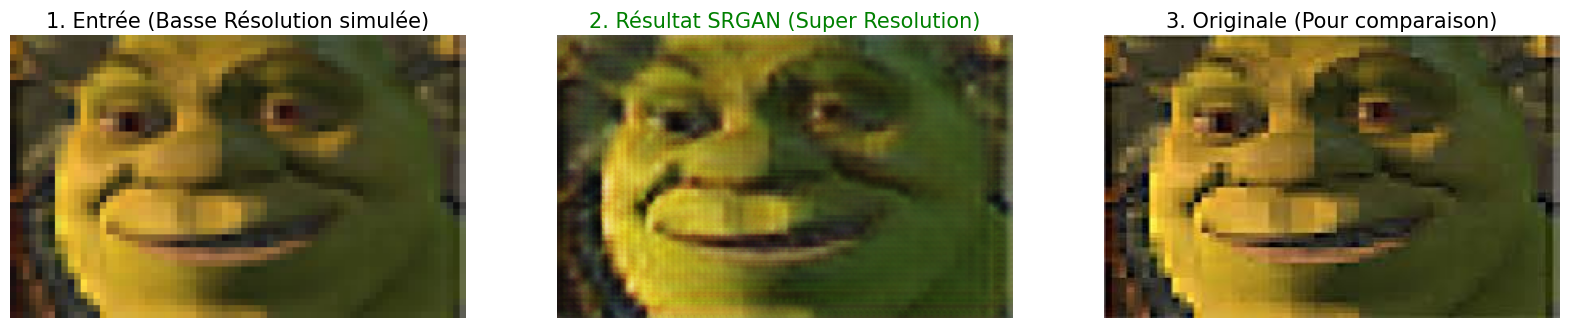

✅ Image sauvegardée sous : resultat_srgan_images.jpeg


In [9]:
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

# 1. Fonction d'upload et de test
def test_custom_image():
    print("📤 Veuillez uploader une image de test (JPG ou PNG)...")
    uploaded = files.upload()

    for fn in uploaded.keys():
        print(f'Processing {fn}...')

        # 2. Chargement et Préparation
        img_path = fn
        original = Image.open(img_path).convert("RGB")

        # On redimensionne l'original pour qu'il soit divisible par 4 (plus propre pour le test)
        w, h = original.size
        w, h = (w // 4) * 4, (h // 4) * 4
        original = original.resize((w, h), Image.BICUBIC)

        # Création de l'entrée "Basse Résolution" (Ce que le modèle va voir)
        # On réduit l'image par 4 -> Elle devient floue/pixelisée
        lr_image = original.resize((w // 4, h // 4), Image.BICUBIC)

        # 3. Inférence (Passage dans le modèle)
        generator.eval() # Mode évaluation
        with torch.no_grad():
            # Transformation en Tenseur + Envoi sur GPU
            img_tensor = transforms.ToTensor()(lr_image).unsqueeze(0).to(DEVICE)

            # Génération
            sr_tensor = generator(img_tensor)

            # Récupération du résultat (GPU -> CPU -> Image)
            sr_image = transforms.ToPILImage()(sr_tensor.squeeze(0).cpu())

        # 4. Affichage des résultats
        fig, axes = plt.subplots(1, 3, figsize=(20, 10))

        # Image Basse Résolution (Zoomée pour qu'on voie les pixels)
        # On utilise NEAREST pour bien montrer les gros pixels moches
        lr_display = lr_image.resize((w, h), Image.NEAREST)
        axes[0].imshow(lr_display)
        axes[0].set_title("1. Entrée (Basse Résolution simulée)", fontsize=15)
        axes[0].axis('off')

        # Résultat SRGAN
        axes[1].imshow(sr_image)
        axes[1].set_title("2. Résultat SRGAN (Super Resolution)", fontsize=15, color='green')
        axes[1].axis('off')

        # Vérité Terrain (L'originale)
        axes[2].imshow(original)
        axes[2].set_title("3. Originale (Pour comparaison)", fontsize=15)
        axes[2].axis('off')

        plt.show()

        # Sauvegarde du résultat
        sr_image.save(f"resultat_srgan_{fn}")
        print(f"✅ Image sauvegardée sous : resultat_srgan_{fn}")

# Lancer la fonction
test_custom_image()